In [1]:
!pip install GPUtil contractions

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.9 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=800850e8e31eb54c5035bdb49c5bbdec681f1592548dde6fe1ca7ca98ebbceba
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [2]:
# ===== Set up project ======
import os
import shutil

# Copy source code to working directory
src_path = r"/kaggle/input/machine-learning-resource/"
dst_path = r"/kaggle/working/machine-learning-resource/"

shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

'/kaggle/working/machine-learning-resource/'

In [3]:
# Add root directory to PYTHON path
import sys
from pathlib import Path

# === LOCAL ===
# root_dir = str(Path.cwd().parent.parent.absolute())
# if not root_dir in sys.path:
#     sys.path.insert(0, root_dir)

# === KAGGLE ===
root_dir = "/kaggle/working/machine-learning-resource"
if not root_dir in sys.path:
    sys.path.insert(0, root_dir)

# **Model Training - LSTM & BiLSTM**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from config import Config
from src.utils.gpu_utils import GPUMemoryManager
from src.data.preprocessing import DataPreprocessor
from src.models.bilstm_attention import BiLSTMAttentionModel
from src.models.lstm_attention import LSTMAttentionModel
from src.training.trainer import ModelTrainer
from src.utils.helpers import save_tokenizer

2025-10-23 17:52:17.105981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761241937.302717      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761241937.352359      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Copy outputs from previous version to working directory 
# (Used to continue training the model if the allowed session runs out)
input_dirs = [
    d for d in os.listdir('/kaggle/input/') if 'machine-translation-project' in d
]

if input_dirs:
    input_dir = f"/kaggle/input/{input_dirs[0]}/machine-learning-resource/"
    work_dir = "/kaggle/working/machine-learning-resource/"
    
    os.makedirs(input_dir, exist_ok=True)
    shutil.copytree(
        input_dir, 
        work_dir, 
        ignore=shutil.ignore_patterns("src"), 
        dirs_exist_ok=True
    )
    
    print("Loaded outputs from previous version")
else:
    print("No previous outputs found. Starting fresh.")

Loaded outputs from previous version


## **1. GPU Setup**

In [6]:
GPUMemoryManager.clear_session()
GPUMemoryManager.setup_gpu(
    memory_limit_mb=Config.GPU_MEMORY_LIMIT,
    allow_growth=Config.GPU_MEMORY_GROWTH
)
if Config.USE_MIXED_PRECISION:
    GPUMemoryManager.enable_mixed_precision()
    GPUMemoryManager.get_memory_info()

Session cleared
GPU memory growth enabled
GPU memory limited to 15000 MB
Found 1 GPU(s)
Mixed precision enabled: mixed_float16
Compute dtype: float16
Variable dtype: float32
GPU 0: 3 MB / 16384 MB (0.0%)


## **2. Configuration**

In [7]:
config = Config.to_dict()

print("Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

print("\nMemory Estimate:")
for key, value in Config.estimate_memory().items():
    print(f"   {key}: {value}")

Configuration:
   batch_size: 128
   epochs: 100
   validation_split: 0.1
   learning_rate: 0.001
   beta_1: 0.9
   beta_2: 0.98
   optimizer_epsilon: 1e-09
   optimizer_dynamic: True
   optimizer_initial_scale: 32768
   optimizer_dynamic_growth_steps: 2000
   use_lr_scheduler: True
   warmup_steps: 8000
   total_steps: 100000
   min_lr: 1e-07
   early_stopping_patience: 5
   reduce_lr_patience: 3
   reduce_lr_factor: 0.5
   save_best_only: True
   monitor: val_loss
   tensorboard_update_freq: epoch
   max_vocab_size_src: 30000
   max_vocab_size_trg: 25000
   min_word_frequency: 1
   embedding_dim: 64
   lstm_units: 128
   attention_heads: 4
   layer_dropout: 0.2
   lstm_dropout: 0.2
   attention_dropout: 0.1
   ln_epsilon: 1e-06
   max_length_src: 40
   max_length_trg: 50
   use_mixed_precision: True
   gpu_memory_growth: True
   gpu_memory_limit: 15000
   label_smoothing: 0.05
   use_layer_norm: True
   beam_width: 5
   use_beam_search: True

Memory Estimate:
   total_params: 10,444,

## **3. Data Preprocessing**

In [8]:
# Tokenizer
tokenizer_path = f"{Config.ARTIFACT_PATH}/tokenizers"
processed_data_path = f"{Config.DATA_PATH}/processed/processed_df.csv"

preprocessor = DataPreprocessor(
    max_vocab_src=Config.MAX_VOCAB_SIZE_SRC,
    max_vocab_trg=Config.MAX_VOCAB_SIZE_TRG,
    min_frequency=Config.MIN_WORD_FREQUENCY,
    expand_contractions=True,
    remove_punctuation=True,
    name_logger='data_preprocessing',
    filename_logger=f'{Config.LOG_DIR}/data_preprocessing.log'
)

if not os.path.exists(processed_data_path):
    print("Processing data from scratch...")
    
    # Load data
    df = preprocessor.load_data(
        src_path=f"{Config.DATA_PATH}/raw/en.txt",
        trg_path=f"{Config.DATA_PATH}/raw/vi.txt",
        max_length_src=Config.MAX_LENGTH_SRC,
        max_length_trg=Config.MAX_LENGTH_TRG
    )
    
    # Save processed data
    os.makedirs(os.path.dirname(processed_data_path), exist_ok=True)
    df.to_csv(processed_data_path, index=False)
    print(f"Saved processed data to {processed_data_path}")
else:
    print("Loading cached processed data...")
    df = pd.read_csv(processed_data_path, encoding="utf-8")

print(f"Dataset: {df.shape}")

Loading cached processed data...
Dataset: (143144, 2)


In [9]:
# Split
train_df, val_df, test_df = preprocessor.split_data(df)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

tokenizer_en_path = f'{tokenizer_path}/tokenizer_en.pkl'
tokenizer_vi_path = f'{tokenizer_path}/tokenizer_vi.pkl'

if not os.path.exists(tokenizer_en_path):
    print("Building tokenizers from scratch...")
    tokenizer_en, tokenizer_vi = preprocessor.build_tokenizers(train_df)
    
    # Save
    os.makedirs(tokenizer_path, exist_ok=True)
    save_tokenizer(tokenizer_en, tokenizer_en_path)
    save_tokenizer(tokenizer_vi, tokenizer_vi_path)
    print(f"Saved tokenizers to {tokenizer_path}")
else:
    print("Loading cached tokenizers...")
    from src.utils import load_tokenizer
    tokenizer_en = load_tokenizer(tokenizer_en_path)
    tokenizer_vi = load_tokenizer(tokenizer_vi_path)
    preprocessor.tokenizer_src = tokenizer_en
    preprocessor.tokenizer_trg = tokenizer_vi

print(f"English vocab size: {len(tokenizer_en.word_index)}")
print(f"Vietnamese vocab size: {len(tokenizer_vi.word_index)}")

Train: 114515, Val: 14314, Test: 14315
Loading cached tokenizers...
Tokenizer loaded from .../artifacts/tokenizers/tokenizer_en.pkl
Tokenizer loaded from .../artifacts/tokenizers/tokenizer_vi.pkl
English vocab size: 36621
Vietnamese vocab size: 27045


In [10]:
# Prepare sequences
en_train, vi_in_train, vi_out_train = preprocessor.prepare_sequences(
    data=train_df,
    max_len_src=Config.MAX_LENGTH_SRC,
    max_len_trg=Config.MAX_LENGTH_TRG
)

en_val, vi_in_val, vi_out_val = preprocessor.prepare_sequences(
    data=val_df,
    max_len_src=Config.MAX_LENGTH_SRC,
    max_len_trg=Config.MAX_LENGTH_TRG
)

print(f"Training sequences: {en_train.shape}")

2025-10-23 17:53:01 - data_preprocessing - INFO - Sequences memory: 61.16 MB
2025-10-23 17:53:02 - data_preprocessing - INFO - Sequences memory: 7.64 MB
Training sequences: (114515, 40)


## **4. Build BiLSTM Model**

In [11]:
model_builder = BiLSTMAttentionModel(
    config=Config,
    name_logger="bilstm_attention",
    filename_logger=f"{Config.LOG_DIR}/bilstm_attention.log"
)
bilstm_model = model_builder.build(
    vocab_size_src=Config.MAX_VOCAB_SIZE_SRC,
    vocab_size_trg=Config.MAX_VOCAB_SIZE_TRG,
    max_len_src=Config.MAX_LENGTH_SRC,
    max_len_trg=Config.MAX_LENGTH_TRG
)

bilstm_model.summary()

I0000 00:00:1761241982.380087      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15000 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "bilstm_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 40, 64)    │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ln1         │ (None, 40, 64)    │        128 │ encoder_embeddin… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 50, 64)    │  1,600,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 40, 64)    │          0 │ encoder_ln1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_ln1         │ (None, 50, 64)    │        128 │ decoder_embeddin… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bilstm      │ [(None, 40, 256), │    197,632 │ encoder_dropout[… │
│ (Bidirectional)     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 50, 64)    │          0 │ decoder_ln1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 50, 256), │    328,704 │ decoder_dropout[… │
│                     │ (None, 256),      │            │ concatenate[0][0… │
│                     │ (None, 256)]      │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_ln2         │ (None, 50, 256)   │        512 │ decoder_lstm[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ln2         │ (None, 40, 256)   │        512 │ encoder_bilstm[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,399,720 (66.37 MB)

 Trainable params: 17,399,720 (66.37 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for layer in bilstm_model.layers[:5]:
    print(f"{layer.name}: dtype={layer.dtype}, compute_dtype={layer.compute_dtype}")

encoder_input: dtype=int32, compute_dtype=float16
encoder_embedding: dtype=float32, compute_dtype=float32
decoder_input: dtype=int32, compute_dtype=float16
encoder_ln1: dtype=float32, compute_dtype=float16
decoder_embedding: dtype=float32, compute_dtype=float32


## **5. Train BiLSTM**

In [13]:
steps_per_epoch = len(en_train) // Config.BATCH_SIZE
Config.TOTAL_STEPS = steps_per_epoch * Config.EPOCHS
model_name = "bilstm"

print(f"Total training steps: {Config.TOTAL_STEPS}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Batch size (global): {Config.BATCH_SIZE}")

trainer = ModelTrainer(
    model=bilstm_model, 
    config=Config, 
    model_name=model_name,
    logger_name="bilstm_attention",
    logger_file=f"{Config.LOG_DIR}/bilstm_attention.log"
)

bilstm_history = trainer.train(
    train_data=(en_train, vi_in_train, vi_out_train),
    val_data=(en_val, vi_in_val, vi_out_val),
    resume=True
)

Total training steps: 89400
Steps per epoch: 894
Batch size (global): 128
2025-10-23 17:53:03 - bilstm_attention - INFO - Loading checkpoint: /kaggle/working/machine-learning-resource/artifacts/bilstm/checkpoints/checkpoint_epoch_070.keras
2025-10-23 17:53:05 - bilstm_attention - INFO - Resuming from epoch 70
2025-10-23 17:53:05 - bilstm_attention - INFO - Mixed precision optimizer enabled with increased stability
2025-10-23 17:53:05 - bilstm_attention - INFO - Model compiled:
2025-10-23 17:53:05 - bilstm_attention - INFO - Loss: Label Smoothing (α=0.05)
2025-10-23 17:53:05 - bilstm_attention - INFO - LR Schedule: True
2025-10-23 17:53:05 - bilstm_attention - INFO - Training started:
2025-10-23 17:53:05 - bilstm_attention - INFO - Batch size: 128
2025-10-23 17:53:05 - bilstm_attention - INFO - Initial epoch: 70
2025-10-23 17:53:05 - bilstm_attention - INFO - Total epochs: 100
2025-10-23 17:53:05 - src.training.callbacks - INFO - Loaded existing history with 77 epochs
Epoch 71/100
895/8

In [14]:
# Save model
model_path = f"{Config.ARTIFACT_PATH}/{model_name}"
os.makedirs(model_path, exist_ok=True)
trainer.save_model(f"{model_path}/final_bilstm_model.keras")

2025-10-23 18:48:38 - bilstm_attention - INFO - Model saved to .../artifacts/bilstm/final_bilstm_model.keras


## **6. Build LSTM Model**

In [15]:
GPUMemoryManager.clear_session()

lstm_builder = LSTMAttentionModel(
    config=Config,
    name_logger="lstm_attention",
    filename_logger=f"{Config.LOG_DIR}/lstm_attention.log"
)
lstm_model = lstm_builder.build(
    vocab_size_src=Config.MAX_VOCAB_SIZE_SRC,
    vocab_size_trg=Config.MAX_VOCAB_SIZE_TRG,
    max_len_src=Config.MAX_LENGTH_SRC,
    max_len_trg=Config.MAX_LENGTH_TRG
)

lstm_model.summary()

Session cleared


Model: "lstm_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 40, 64)    │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 50, 64)    │  1,600,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ln1         │ (None, 40, 64)    │        128 │ encoder_embeddin… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_ln1         │ (None, 50, 64)    │        128 │ decoder_embeddin… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 40, 64)    │          0 │ encoder_ln1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 50, 64)    │          0 │ decoder_ln1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 40, 128), │     98,816 │ encoder_dropout[… │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 50, 128), │     98,816 │ decoder_dropout[… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_ln2         │ (None, 50, 128)   │        256 │ decoder_lstm[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_ln2         │ (None, 40, 128)   │        256 │ encoder_lstm[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 50, 128)   │    263,808 │ encoder_ln2[0][0… │
│ (MultiHeadAttentio… │                   │            │ not_equal[0][0],  │
│                     │                   │            │ decoder_ln2[0][0… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ encoder_ln2[0][0

 Total params: 10,407,720 (39.70 MB)

 Trainable params: 10,407,720 (39.70 MB)

 Non-trainable params: 0 (0.00 B)

## **7. Train LSTM**

In [16]:
model_name = "lstm"

lstm_trainer = ModelTrainer(
    model=lstm_model,
    config=Config,
    model_name=model_name,
    logger_name="lstm_attention",
    logger_file=f"{Config.LOG_DIR}/lstm_attention.log"
)

lstm_history = lstm_trainer.train(
    train_data=(en_train, vi_in_train, vi_out_train),
    val_data=(en_val, vi_in_val, vi_out_val),
    resume=True
)

2025-10-23 18:48:41 - lstm_attention - INFO - No checkpoint directory found. Starting from scratch.
2025-10-23 18:48:41 - lstm_attention - INFO - Mixed precision optimizer enabled with increased stability
2025-10-23 18:48:41 - lstm_attention - INFO - Model compiled:
2025-10-23 18:48:41 - lstm_attention - INFO - Loss: Label Smoothing (α=0.05)
2025-10-23 18:48:41 - lstm_attention - INFO - LR Schedule: True
2025-10-23 18:48:41 - lstm_attention - INFO - Training started:
2025-10-23 18:48:41 - lstm_attention - INFO - Batch size: 128
2025-10-23 18:48:41 - lstm_attention - INFO - Initial epoch: 0
2025-10-23 18:48:41 - lstm_attention - INFO - Total epochs: 100
Epoch 1/100
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5073 - loss: 7.6140
Epoch 1: val_loss improved from inf to 2.50783, saving model to /kaggle/working/machine-learning-resource/artifacts/lstm/checkpoints/best_model.keras
2025-10-23 18:55:02 - src.training.callbacks - INFO - GPU Memory: 15269/16384 MB (93.2%) | Peak: 152

In [17]:
# Save
model_path = f"{Config.ARTIFACT_PATH}/{model_name}"
os.makedirs(model_path, exist_ok=True)
lstm_trainer.save_model(f"{model_path}/final_lstm_model.keras")

2025-10-24 05:01:42 - lstm_attention - INFO - Model saved to .../artifacts/lstm/final_lstm_model.keras


## **8. Compare Results**

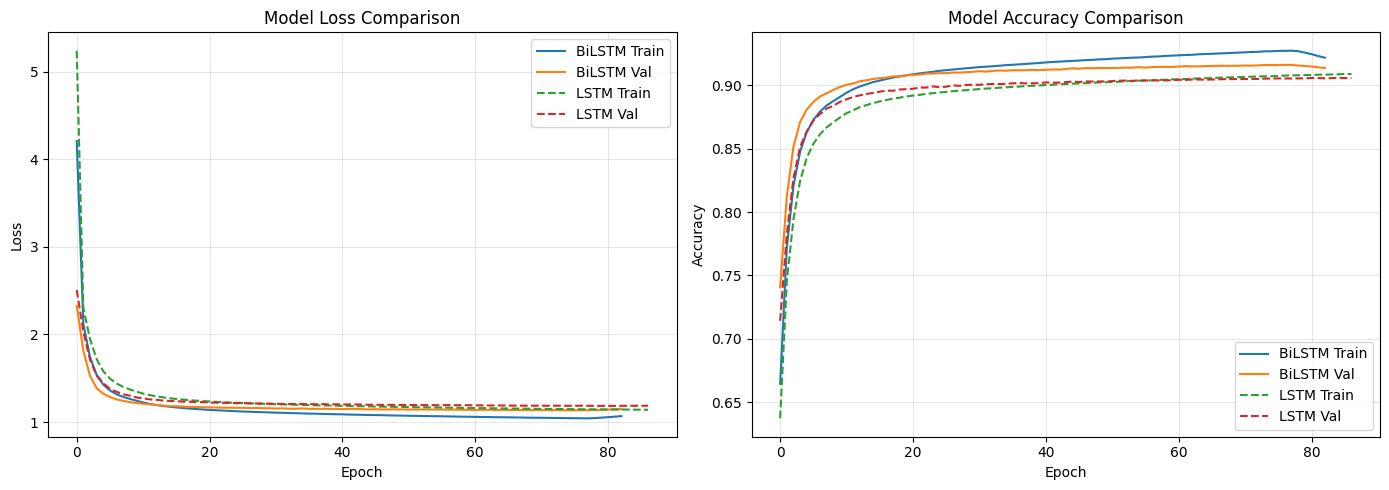

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(bilstm_history.history['loss'], label='BiLSTM Train')
axes[0].plot(bilstm_history.history['val_loss'], label='BiLSTM Val')
axes[0].plot(lstm_history.history['loss'], label='LSTM Train', linestyle='--')
axes[0].plot(lstm_history.history['val_loss'], label='LSTM Val', linestyle='--')
axes[0].set_title('Model Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(bilstm_history.history['accuracy'], label='BiLSTM Train')
axes[1].plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val')
axes[1].plot(lstm_history.history['accuracy'], label='LSTM Train', linestyle='--')
axes[1].plot(lstm_history.history['val_accuracy'], label='LSTM Val', linestyle='--')
axes[1].set_title('Model Accuracy Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
os.makedirs(Config.ASSETS_PATH, exist_ok=True)
plt.savefig(f"{Config.ASSETS_PATH}/comparison.png", dpi=300)
plt.show()

In [19]:
print(f"BiLSTM - Final Val Loss: {bilstm_history.history['val_loss'][-1]:.4f}")
print(f"LSTM - Final Val Loss: {lstm_history.history['val_loss'][-1]:.4f}")

BiLSTM - Final Val Loss: 1.1470
LSTM - Final Val Loss: 1.1859
